<a href="https://colab.research.google.com/github/xelothi/CRAF_for_a_paper/blob/main/CRAF_data_preprocessing_and_EDA(.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and importing necessary libraries

In [1]:
! pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 19.7 MB/s eta 0:00:00


In [2]:
! pip install chembl_webresource_client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
from chembl_webresource_client.new_client import *
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.SaltRemover import SaltRemover
import numpy as np
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem.FilterCatalog import *
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy
import math

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry> already registered; second conversion method ignored.


# Searh for target CRAf protein in the CHEMBL database

In [13]:
target = new_client.target
target_search = target.search("cRAF")
targets = pd.DataFrame.from_dict(target_search)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Homo sapiens,BRAF/CRAF,18.0,False,CHEMBL4106189,"[{'accession': 'P04049', 'component_descriptio...",PROTEIN COMPLEX,9606
1,[],Mus musculus,RAF proto-oncogene serine/threonine-protein ki...,17.0,False,CHEMBL3804748,"[{'accession': 'Q99N57', 'component_descriptio...",SINGLE PROTEIN,10090
2,[],Homo sapiens,Serine/threonine-protein kinase RAF,15.0,False,CHEMBL1906,"[{'accession': 'P04049', 'component_descriptio...",SINGLE PROTEIN,9606
3,[],Homo sapiens,14-3-3 eta/c-RAF,14.0,False,CHEMBL5291962,"[{'accession': 'P04049', 'component_descriptio...",PROTEIN COMPLEX,9606
4,[],Homo sapiens,GTPase KRas/RAF1,13.0,False,CHEMBL5291977,"[{'accession': 'P04049', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
5,[],Homo sapiens,B-raf/RAF proto-oncogene serine/threonine-prot...,12.0,False,CHEMBL3883317,"[{'accession': 'P04049', 'component_descriptio...",PROTEIN FAMILY,9606
6,[],Homo sapiens,Serine/threonine-protein kinase RAF and Dual s...,11.0,False,CHEMBL2111351,"[{'accession': 'P04049', 'component_descriptio...",PROTEIN FAMILY,9606
7,[],Homo sapiens,RAF serine/threonine protein kinase,11.0,False,CHEMBL3559685,"[{'accession': 'P04049', 'component_descriptio...",PROTEIN FAMILY,9606
8,[],Homo sapiens,Dual specificity mitogen-activated protein kin...,8.0,False,CHEMBL3885566,"[{'accession': 'P28482', 'component_descriptio...",PROTEIN FAMILY,9606


# Retrieving bioactivity data for CRAF


In [14]:
selected_target = targets.target_chembl_id[2]
assay = new_client.assay
res = assay.filter(target_chembl_id=selected_target).filter(confidence_score="9")
df_assay = pd.DataFrame.from_dict(res)
df_assay

,aidx,assay_category,assay_cell_type,assay_chembl_id,assay_classifications,assay_group,assay_organism,assay_parameters,assay_strain,assay_subcellular_fraction,...,confidence_score,description,document_chembl_id,relationship_description,relationship_type,src_assay_id,src_id,target_chembl_id,tissue_chembl_id,variant_sequence
0,CLD0,None,None,CHEMBL857421,[],None,Homo sapiens,[],None,None,...,9,Inhibition of c-Raf1 kinase,CHEMBL1147447,Direct protein target assigned,D,None,1,CHEMBL1906,None,None
1,CLD0,None,None,CHEMBL765224,[],None,Homo sapiens,[],None,None,...,9,Inhibition of RAF proto-oncogene serine/threon...,CHEMBL1146654,Direct protein target assigned,D,None,1,CHEMBL1906,None,None
2,CLD0,None,None,CHEMBL765225,[],None,Homo sapiens,[],None,None,...,9,Inhibition of human RAF proto-oncogene serine/...,CHEMBL1145082,Direct protein target assigned,D,None,1,CHEMBL1906,None,None
3,CLD0,None,None,CHEMBL765227,[],None,Homo sapiens,[],None,None,...,9,Inhibition of human RAF proto-oncogene serine/...,CHEMBL1147483,Direct protein target assigned,D,None,1,CHEMBL1906,None,None
4,CLD0,None,None,CHEMBL765228,[],None,Homo sapiens,[],None,None,...,9,Inhibition of human RAF proto-oncogene serine/...,CHEMBL1147484,Direct protein target assigned,D,None,1,CHEMBL1906,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,S_37082_545_334132,Selectivity assay,None,CHEMBL5481931,[],None,Homo sapiens,"[{'active': 1, 'comments': None, 'relation': N...",None,None,...,9,Selectivity interaction (KinomeScan (DiscoverX...,CHEMBL5465560,Direct protein target assigned,D,None,65,CHEMBL1906,None,None
500,S_37082_545_334133,Selectivity assay,None,CHEMBL5481932,[],None,Homo sapiens,"[{'active': 1, 'comments': None, 'relation': N...",None,None,...,9,Selectivity interaction (KinomeScan (DiscoverX...,CHEMBL5465560,Direct protein target assigned,D,None,65,CHEMBL1906,None,None
501,S_37090_545_343095,Selectivity assay,None,CHEMBL5482592,[],None,Homo sapiens,"[{'active': 1, 'comments': None, 'relation': N...",None,None,...,9,Selectivity interaction (Kinase panel (Z-LYTE ...,CHEMBL5465560,Direct protein target assigned,D,None,65,CHEMBL1906,None,"{'accession': 'P04049', 'isoform': 1, 'mutatio..."
502,S_37090_545_343096,Selectivity assay,None,CHEMBL5482593,[],None,Homo sapiens,"[{'active': 1, 'comments': None, 'relation': N...",None,None,...,9,Selectivity interaction (LanthaScreen Eu Kinas...,CHEMBL5465560,Direct protein target assigned,D,None,65,CHEMBL1906,None,"{'accession': 'P04049', 'isoform': 1, 'mutatio..."


In [15]:
selected_target = targets.target_chembl_id[2]
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(type="IC50").filter(assay_type="B")
df = pd.DataFrame.from_dict(res)
df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,392442,[],CHEMBL766737,Inhibitory concentration against raf kinase.,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,uM,UO_0000065,None,4.9
1,None,None,392494,[],CHEMBL766737,Inhibitory concentration against raf kinase.,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,uM,UO_0000065,None,15.0
2,None,None,392495,[],CHEMBL766737,Inhibitory concentration against raf kinase.,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,uM,UO_0000065,None,16.0
3,None,None,393629,[],CHEMBL766737,Inhibitory concentration against raf kinase.,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,uM,UO_0000065,None,1.7
4,None,None,394910,[],CHEMBL820189,Inhibition of cRaf kinase,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1957,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25663321,[],CHEMBL5374192,Inhibition of RAF-1 (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,6.0
1958,None,None,25679860,[],CHEMBL5379555,Inhibition of RAF1 (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,uM,UO_0000065,None,10.0
1959,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25708393,[],CHEMBL5387506,Inhibition of C-Raf (unknown origin) in presen...,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,5.0
1960,None,None,25781304,"[{'comments': None, 'relation': None, 'result_...",CHEMBL5466076,Selectivity interaction (Whole cell assay (usi...,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,2.45


In [17]:
# Create a boolean mask to identify rows to drop
mask = df['assay_chembl_id'].isin(df_assay['assay_chembl_id'])

# Use the mask to filter the DataFrame and keep only rows where the condition is True
df = df[mask]

In [20]:
# Count occurrences of each 'document_chembl_id'
counts = df['document_chembl_id'].value_counts()

# Filter rows with at least three occurrences of 'document_chembl_id'
filtered_df = df[df['document_chembl_id'].isin(counts[counts >= 3].index)]
filtered_df.to_csv("CRAF_all.csv")

In [21]:
df.standard_type.unique()

array(['IC50'], dtype=object)

# Handling missing data

In [22]:
df2 = filtered_df[df.standard_value.notna()]
df2 = filtered_df[df.molecule_chembl_id.notna()]
df2 = filtered_df[df.canonical_smiles.notna()]
df2

<ipython-input-22-76c0997f7d29>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = filtered_df[df.standard_value.notna()]
<ipython-input-22-76c0997f7d29>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = filtered_df[df.molecule_chembl_id.notna()]
<ipython-input-22-76c0997f7d29>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = filtered_df[df.canonical_smiles.notna()]


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
42,None,None,433486,[],CHEMBL820579,Inhibition of human c-Raf kinase,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,320.0
49,None,None,437170,[],CHEMBL820579,Inhibition of human c-Raf kinase,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,810.0
55,None,None,446735,[],CHEMBL820579,Inhibition of human c-Raf kinase,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,1000.0
65,None,None,468912,[],CHEMBL820579,Inhibition of human c-Raf kinase,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,330.0
67,None,None,470279,[],CHEMBL820579,Inhibition of human c-Raf kinase,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,3500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1943,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24867133,[],CHEMBL5151918,Inhibition of RAF1 (305 to 648 residues) (unkn...,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,2.5
1944,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24867223,[],CHEMBL5152008,Inhibition of CRAF (unknown origin) by kinomes...,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,146.0
1948,None,None,24984783,[],CHEMBL5227435,Inhibition of c-Raf (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,10000.0
1949,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24984784,[],CHEMBL5227435,Inhibition of c-Raf (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,uM,UO_0000065,None,38.0


# Removing duplicates

Because data was taken from multiple scientific papers, it is possible that the different papers tested the same substance. We want to clean the data from any duplicates

In [23]:
selection = ["molecule_chembl_id", "canonical_smiles", "standard_value"]
conc_data = df2[selection]
conc_data = conc_data.dropna()

#Standardize

Adapted from: https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/Standardization%20and%20Validation%20with%20the%20RDKit.ipynb

In [24]:
# Borrowed from https://bitsilla.com/blog/2021/06/standardizing-a-molecule-using-rdkit/
def standardize(smiles):
    # follows the steps in
    # https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
    # as described **excellently** (by Greg) in
    # https://www.youtube.com/watch?v=eWTApNX8dJQ
    mol = Chem.MolFromSmiles(smiles)

    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol)

    # if many fragments, get the "parent" (the actual mol we are interested in)
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)

    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger()  # annoying, but necessary as no convenience method exists
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)

    # note that no attempt is made at reionization at this step
    # nor at ionization at some pH (rdkit has no pKa caculator)
    # the main aim to represent all molecules from different sources
    # in a (single) standard way, for use in ML, catalogue, etc.

    te = rdMolStandardize.TautomerEnumerator()  # idem
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)

    return Chem.MolToSmiles(taut_uncharged_parent_clean_mol)


In [25]:
smiles_df = conc_data["canonical_smiles"].apply(standardize)
smiles_df

Streaming output truncated to the last 5000 lines.
[13:50:31] Initializing MetalDisconnector
[13:50:31] Running MetalDisconnector
[13:50:31] Initializing Normalizer
[13:50:31] Running Normalizer
[13:50:31] Initializing MetalDisconnector
[13:50:31] Running MetalDisconnector
[13:50:31] Initializing Normalizer
[13:50:31] Running Normalizer
[13:50:31] Running LargestFragmentChooser
[13:50:31] Running Uncharger
[13:50:31] Initializing MetalDisconnector
[13:50:31] Running MetalDisconnector
[13:50:31] Initializing Normalizer
[13:50:31] Running Normalizer
[13:50:31] Initializing MetalDisconnector
[13:50:31] Running MetalDisconnector
[13:50:31] Initializing Normalizer
[13:50:31] Running Normalizer
[13:50:31] Running LargestFragmentChooser
[13:50:31] Running Uncharger
[13:50:31] Initializing MetalDisconnector
[13:50:31] Running MetalDisconnector
[13:50:31] Initializing Normalizer
[13:50:31] Running Normalizer
[13:50:31] Initializing MetalDisconnector
[13:50:31] Running MetalDisconnector
[13:50:3

,canonical_smiles
42,COC(=O)c1ccc(-c2[nH]c(-c3ccccc3)nc2-c2ccncc2)cc1
49,C[C@H](Nc1cc(-c2c(-c3cccc(C(F)(F)F)c3)nc(C3CCN...
55,C[C@H](Nc1nccc(-c2c(-c3cccc(C(F)(F)F)c3)nc(C3C...
65,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...
67,C[C@H](Nc1nccc(-c2[nH]c(C3CCNCC3)nc2-c2cccc(C(...
...,...
1943,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...
1944,COc1cc2ncnc(Oc3cccc(NC(=O)Nc4cc(C(C)(C)C(F)(F)...
1948,Nc1nc(C2=CCNC(=O)c3[nH]c(Br)cc32)c(O)[nH]1
1949,O=C1Cc2c([nH]c3ccc(Br)cc23)-c2ccccc2N1


In [26]:
smiles_df = pd.DataFrame(smiles_df).rename(columns={"canonical_smiles": "std_smiles"})
conc_data2 = conc_data.drop(columns="canonical_smiles", axis=1)
final_data = pd.concat([conc_data2,smiles_df], axis=1)
final_data

,molecule_chembl_id,standard_value,std_smiles
42,CHEMBL431583,320.0,COC(=O)c1ccc(-c2[nH]c(-c3ccccc3)nc2-c2ccncc2)cc1
49,CHEMBL303144,810.0,C[C@H](Nc1cc(-c2c(-c3cccc(C(F)(F)F)c3)nc(C3CCN...
55,CHEMBL305178,1000.0,C[C@H](Nc1nccc(-c2c(-c3cccc(C(F)(F)F)c3)nc(C3C...
65,CHEMBL10,330.0,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...
67,CHEMBL308939,3500.0,C[C@H](Nc1nccc(-c2[nH]c(C3CCNCC3)nc2-c2cccc(C(...
...,...,...,...
1943,CHEMBL1946170,2.5,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...
1944,CHEMBL2029988,146.0,COc1cc2ncnc(Oc3cccc(NC(=O)Nc4cc(C(C)(C)C(F)(F)...
1948,CHEMBL361708,10000.0,Nc1nc(C2=CCNC(=O)c3[nH]c(Br)cc32)c(O)[nH]1
1949,CHEMBL296586,38000.0,O=C1Cc2c([nH]c3ccc(Br)cc23)-c2ccccc2N1


In [27]:
duplicates_droped_smi = final_data.drop_duplicates(subset="std_smiles", keep="first").reset_index().drop(columns="index", axis=1)
duplicates_droped_smi = duplicates_droped_smi.dropna()
duplicates_droped_smi

,molecule_chembl_id,standard_value,std_smiles
0,CHEMBL431583,320.0,COC(=O)c1ccc(-c2[nH]c(-c3ccccc3)nc2-c2ccncc2)cc1
1,CHEMBL303144,810.0,C[C@H](Nc1cc(-c2c(-c3cccc(C(F)(F)F)c3)nc(C3CCN...
2,CHEMBL305178,1000.0,C[C@H](Nc1nccc(-c2c(-c3cccc(C(F)(F)F)c3)nc(C3C...
3,CHEMBL10,330.0,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...
4,CHEMBL308939,3500.0,C[C@H](Nc1nccc(-c2[nH]c(C3CCNCC3)nc2-c2cccc(C(...
...,...,...,...
1092,CHEMBL166031,230.0,CC(C)(C)c1cc(NC(=O)Nc2ccc(Oc3ccncc3)cc2)no1
1093,CHEMBL2029988,146.0,COc1cc2ncnc(Oc3cccc(NC(=O)Nc4cc(C(C)(C)C(F)(F)...
1094,CHEMBL361708,10000.0,Nc1nc(C2=CCNC(=O)c3[nH]c(Br)cc32)c(O)[nH]1
1095,CHEMBL296586,38000.0,O=C1Cc2c([nH]c3ccc(Br)cc23)-c2ccccc2N1


# PAINS removal

In [28]:
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

# search for PAINS
matches = []
clean = []
for index, row in tqdm(duplicates_droped_smi.iterrows(), total=duplicates_droped_smi.shape[0]):
    molecule = Chem.MolFromSmiles(row.std_smiles)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
clean_data = duplicates_droped_smi.loc[clean]  # keep molecules without PAINS


  0%|          | 0/1097 [00:00<?, ?it/s]

In [29]:
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(clean_data)}")

Number of compounds with PAINS: 6
Number of compounds without PAINS: 1091


In [30]:
clean_data = clean_data.reset_index(drop=True)

# Lipinski descriptors
Lipinski descriptors,  Lipinski's Rule-of-five, which proposes that molecules with poor permeation and oral absorption have molecular weight > 500, Clog P > 5, hydrogen-bond donor > 5 and hydrogen-bond acceptor > 10.

In [31]:
#Code  from https://codeocean.com/explore/capsules?query=tag:data-curation

def generate(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
        desc_numRotatingBonds = Descriptors.NumRotatableBonds(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors,
                        desc_numRotatingBonds])
        if (i == 0):
          baseData = row
        else:
          baseData = np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors", "numRotatingBonds"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

df_lipinski = generate(clean_data.std_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors,numRotatingBonds
0,355.397,4.5923,1.0,4.0,4.0
1,505.588,6.8080,2.0,5.0,6.0
2,506.576,6.2030,2.0,6.0,6.0
3,377.444,4.6822,1.0,3.0,4.0
4,492.549,6.1926,3.0,5.0,6.0
...,...,...,...,...,...
1086,352.394,4.8034,2.0,5.0,4.0
1087,517.464,5.9112,2.0,8.0,7.0
1088,324.138,0.9632,5.0,4.0,1.0
1089,327.181,4.0920,2.0,1.0,0.0


In [32]:
df_combined = pd.concat([clean_data, df_lipinski], axis=1)
df_combined

,molecule_chembl_id,standard_value,std_smiles,MW,LogP,NumHDonors,NumHAcceptors,numRotatingBonds
0,CHEMBL431583,320.0,COC(=O)c1ccc(-c2[nH]c(-c3ccccc3)nc2-c2ccncc2)cc1,355.397,4.5923,1.0,4.0,4.0
1,CHEMBL303144,810.0,C[C@H](Nc1cc(-c2c(-c3cccc(C(F)(F)F)c3)nc(C3CCN...,505.588,6.8080,2.0,5.0,6.0
2,CHEMBL305178,1000.0,C[C@H](Nc1nccc(-c2c(-c3cccc(C(F)(F)F)c3)nc(C3C...,506.576,6.2030,2.0,6.0,6.0
3,CHEMBL10,330.0,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,377.444,4.6822,1.0,3.0,4.0
4,CHEMBL308939,3500.0,C[C@H](Nc1nccc(-c2[nH]c(C3CCNCC3)nc2-c2cccc(C(...,492.549,6.1926,3.0,5.0,6.0
...,...,...,...,...,...,...,...,...
1086,CHEMBL166031,230.0,CC(C)(C)c1cc(NC(=O)Nc2ccc(Oc3ccncc3)cc2)no1,352.394,4.8034,2.0,5.0,4.0
1087,CHEMBL2029988,146.0,COc1cc2ncnc(Oc3cccc(NC(=O)Nc4cc(C(C)(C)C(F)(F)...,517.464,5.9112,2.0,8.0,7.0
1088,CHEMBL361708,10000.0,Nc1nc(C2=CCNC(=O)c3[nH]c(Br)cc32)c(O)[nH]1,324.138,0.9632,5.0,4.0,1.0
1089,CHEMBL296586,38000.0,O=C1Cc2c([nH]c3ccc(Br)cc23)-c2ccccc2N1,327.181,4.0920,2.0,1.0,0.0


# Convert IC50 to pIC50

In [33]:
def pIC50(i):
    molar = i*(10**-9)
    pIC50 = -np.log10(molar)
    return pIC50

In [34]:
df_combined["norm_value"] = df_combined["standard_value"].astype(float).map(lambda x: 100000000.0  if x > 100000000.0 else x)
df_combined['pIC50'] = df_combined['norm_value'].apply(pIC50)
df_combined = df_combined.drop(columns="standard_value", axis=1)
df_combined


,molecule_chembl_id,std_smiles,MW,LogP,NumHDonors,NumHAcceptors,numRotatingBonds,norm_value,pIC50
0,CHEMBL431583,COC(=O)c1ccc(-c2[nH]c(-c3ccccc3)nc2-c2ccncc2)cc1,355.397,4.5923,1.0,4.0,4.0,320.0,6.494850
1,CHEMBL303144,C[C@H](Nc1cc(-c2c(-c3cccc(C(F)(F)F)c3)nc(C3CCN...,505.588,6.8080,2.0,5.0,6.0,810.0,6.091515
2,CHEMBL305178,C[C@H](Nc1nccc(-c2c(-c3cccc(C(F)(F)F)c3)nc(C3C...,506.576,6.2030,2.0,6.0,6.0,1000.0,6.000000
3,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,377.444,4.6822,1.0,3.0,4.0,330.0,6.481486
4,CHEMBL308939,C[C@H](Nc1nccc(-c2[nH]c(C3CCNCC3)nc2-c2cccc(C(...,492.549,6.1926,3.0,5.0,6.0,3500.0,5.455932
...,...,...,...,...,...,...,...,...,...
1086,CHEMBL166031,CC(C)(C)c1cc(NC(=O)Nc2ccc(Oc3ccncc3)cc2)no1,352.394,4.8034,2.0,5.0,4.0,230.0,6.638272
1087,CHEMBL2029988,COc1cc2ncnc(Oc3cccc(NC(=O)Nc4cc(C(C)(C)C(F)(F)...,517.464,5.9112,2.0,8.0,7.0,146.0,6.835647
1088,CHEMBL361708,Nc1nc(C2=CCNC(=O)c3[nH]c(Br)cc32)c(O)[nH]1,324.138,0.9632,5.0,4.0,1.0,10000.0,5.000000
1089,CHEMBL296586,O=C1Cc2c([nH]c3ccc(Br)cc23)-c2ccccc2N1,327.181,4.0920,2.0,1.0,0.0,38000.0,4.420216


In [58]:
bioactivity = df_combined.pIC50.astype(float)
bioactivity_class = bioactivity.map(lambda x: "inactive" if x <= 6.5 else "active")
bioactivity_class = pd.Series(bioactivity_class, name="bioactivity")
bioactivity_class

,bioactivity
0,inactive
1,inactive
2,inactive
3,inactive
4,inactive
...,...
1086,active
1087,active
1088,inactive
1089,inactive


In [59]:
exp_data = pd.concat([df_combined, bioactivity_class], axis=1)
exp_data

,molecule_chembl_id,std_smiles,MW,LogP,NumHDonors,NumHAcceptors,numRotatingBonds,norm_value,pIC50,bioactivity
0,CHEMBL431583,COC(=O)c1ccc(-c2[nH]c(-c3ccccc3)nc2-c2ccncc2)cc1,355.397,4.5923,1.0,4.0,4.0,320.0,6.494850,inactive
1,CHEMBL303144,C[C@H](Nc1cc(-c2c(-c3cccc(C(F)(F)F)c3)nc(C3CCN...,505.588,6.8080,2.0,5.0,6.0,810.0,6.091515,inactive
2,CHEMBL305178,C[C@H](Nc1nccc(-c2c(-c3cccc(C(F)(F)F)c3)nc(C3C...,506.576,6.2030,2.0,6.0,6.0,1000.0,6.000000,inactive
3,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,377.444,4.6822,1.0,3.0,4.0,330.0,6.481486,inactive
4,CHEMBL308939,C[C@H](Nc1nccc(-c2[nH]c(C3CCNCC3)nc2-c2cccc(C(...,492.549,6.1926,3.0,5.0,6.0,3500.0,5.455932,inactive
...,...,...,...,...,...,...,...,...,...,...
1086,CHEMBL166031,CC(C)(C)c1cc(NC(=O)Nc2ccc(Oc3ccncc3)cc2)no1,352.394,4.8034,2.0,5.0,4.0,230.0,6.638272,active
1087,CHEMBL2029988,COc1cc2ncnc(Oc3cccc(NC(=O)Nc4cc(C(C)(C)C(F)(F)...,517.464,5.9112,2.0,8.0,7.0,146.0,6.835647,active
1088,CHEMBL361708,Nc1nc(C2=CCNC(=O)c3[nH]c(Br)cc32)c(O)[nH]1,324.138,0.9632,5.0,4.0,1.0,10000.0,5.000000,inactive
1089,CHEMBL296586,O=C1Cc2c([nH]c3ccc(Br)cc23)-c2ccccc2N1,327.181,4.0920,2.0,1.0,0.0,38000.0,4.420216,inactive


In [60]:
exp_data.shape

(1091, 10)

In [61]:
exp_data.dropna()

,molecule_chembl_id,std_smiles,MW,LogP,NumHDonors,NumHAcceptors,numRotatingBonds,norm_value,pIC50,bioactivity
0,CHEMBL431583,COC(=O)c1ccc(-c2[nH]c(-c3ccccc3)nc2-c2ccncc2)cc1,355.397,4.5923,1.0,4.0,4.0,320.0,6.494850,inactive
1,CHEMBL303144,C[C@H](Nc1cc(-c2c(-c3cccc(C(F)(F)F)c3)nc(C3CCN...,505.588,6.8080,2.0,5.0,6.0,810.0,6.091515,inactive
2,CHEMBL305178,C[C@H](Nc1nccc(-c2c(-c3cccc(C(F)(F)F)c3)nc(C3C...,506.576,6.2030,2.0,6.0,6.0,1000.0,6.000000,inactive
3,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,377.444,4.6822,1.0,3.0,4.0,330.0,6.481486,inactive
4,CHEMBL308939,C[C@H](Nc1nccc(-c2[nH]c(C3CCNCC3)nc2-c2cccc(C(...,492.549,6.1926,3.0,5.0,6.0,3500.0,5.455932,inactive
...,...,...,...,...,...,...,...,...,...,...
1086,CHEMBL166031,CC(C)(C)c1cc(NC(=O)Nc2ccc(Oc3ccncc3)cc2)no1,352.394,4.8034,2.0,5.0,4.0,230.0,6.638272,active
1087,CHEMBL2029988,COc1cc2ncnc(Oc3cccc(NC(=O)Nc4cc(C(C)(C)C(F)(F)...,517.464,5.9112,2.0,8.0,7.0,146.0,6.835647,active
1088,CHEMBL361708,Nc1nc(C2=CCNC(=O)c3[nH]c(Br)cc32)c(O)[nH]1,324.138,0.9632,5.0,4.0,1.0,10000.0,5.000000,inactive
1089,CHEMBL296586,O=C1Cc2c([nH]c3ccc(Br)cc23)-c2ccccc2N1,327.181,4.0920,2.0,1.0,0.0,38000.0,4.420216,inactive


In [63]:
exp_data.to_csv("CRAF_cleaned.csv")

# Exploratory data analysis

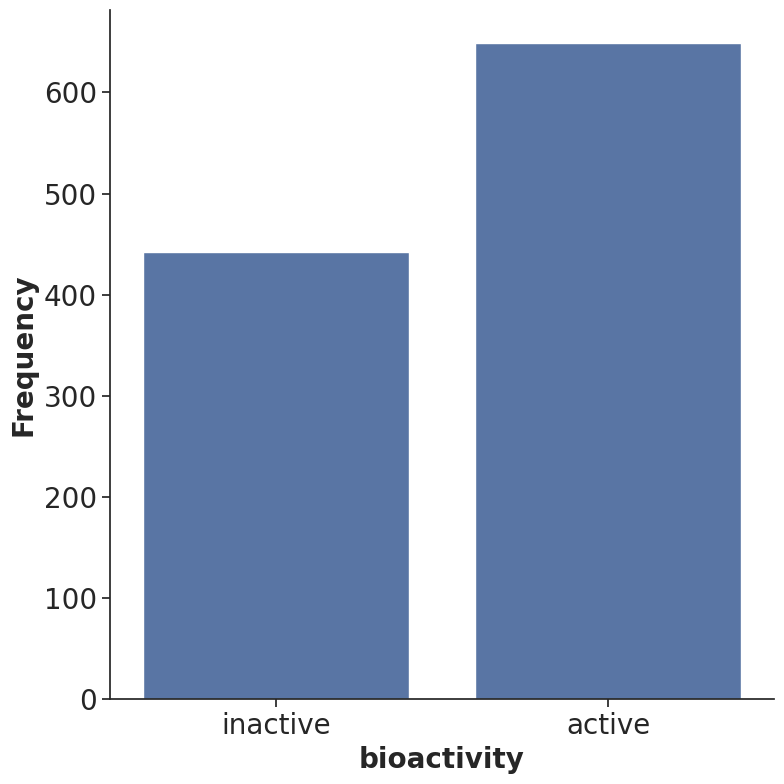

In [64]:
plt.figure(figsize=(8,8))


sns.countplot(x='bioactivity', data=exp_data)
plt.xlabel('bioactivity', size=20, fontweight='bold')
plt.ylabel('Frequency', fontsize=20, fontweight='bold')
plt.xticks(size=20)
plt.yticks(size=20)
sns.set(style='ticks')
sns.despine(top=True)
plt.tight_layout()
plt.savefig('plot_bioactivity_class.png')

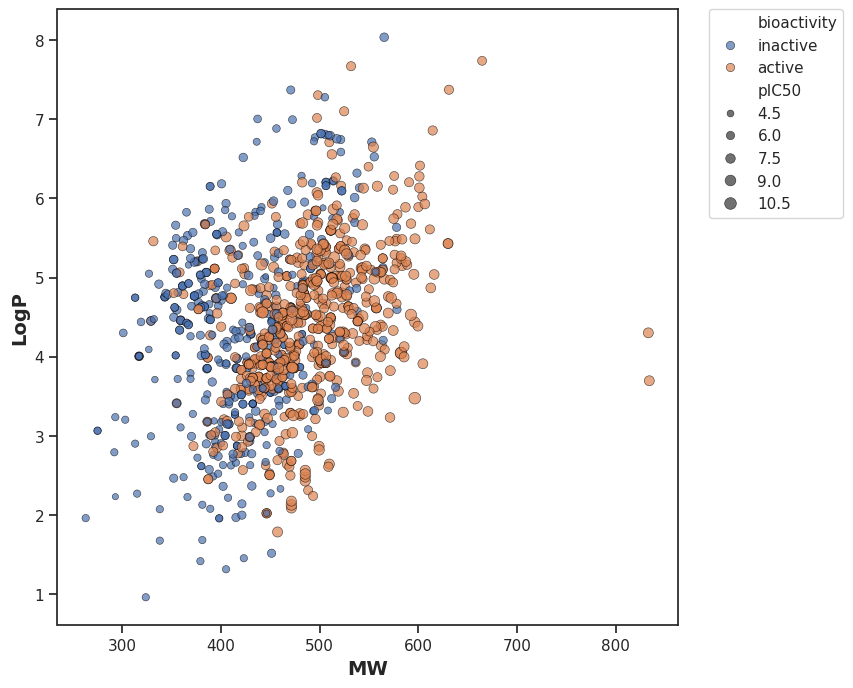

In [65]:
plt.figure(figsize=(8, 8))

sns.scatterplot(x='MW', y='LogP', data=exp_data, hue='bioactivity', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

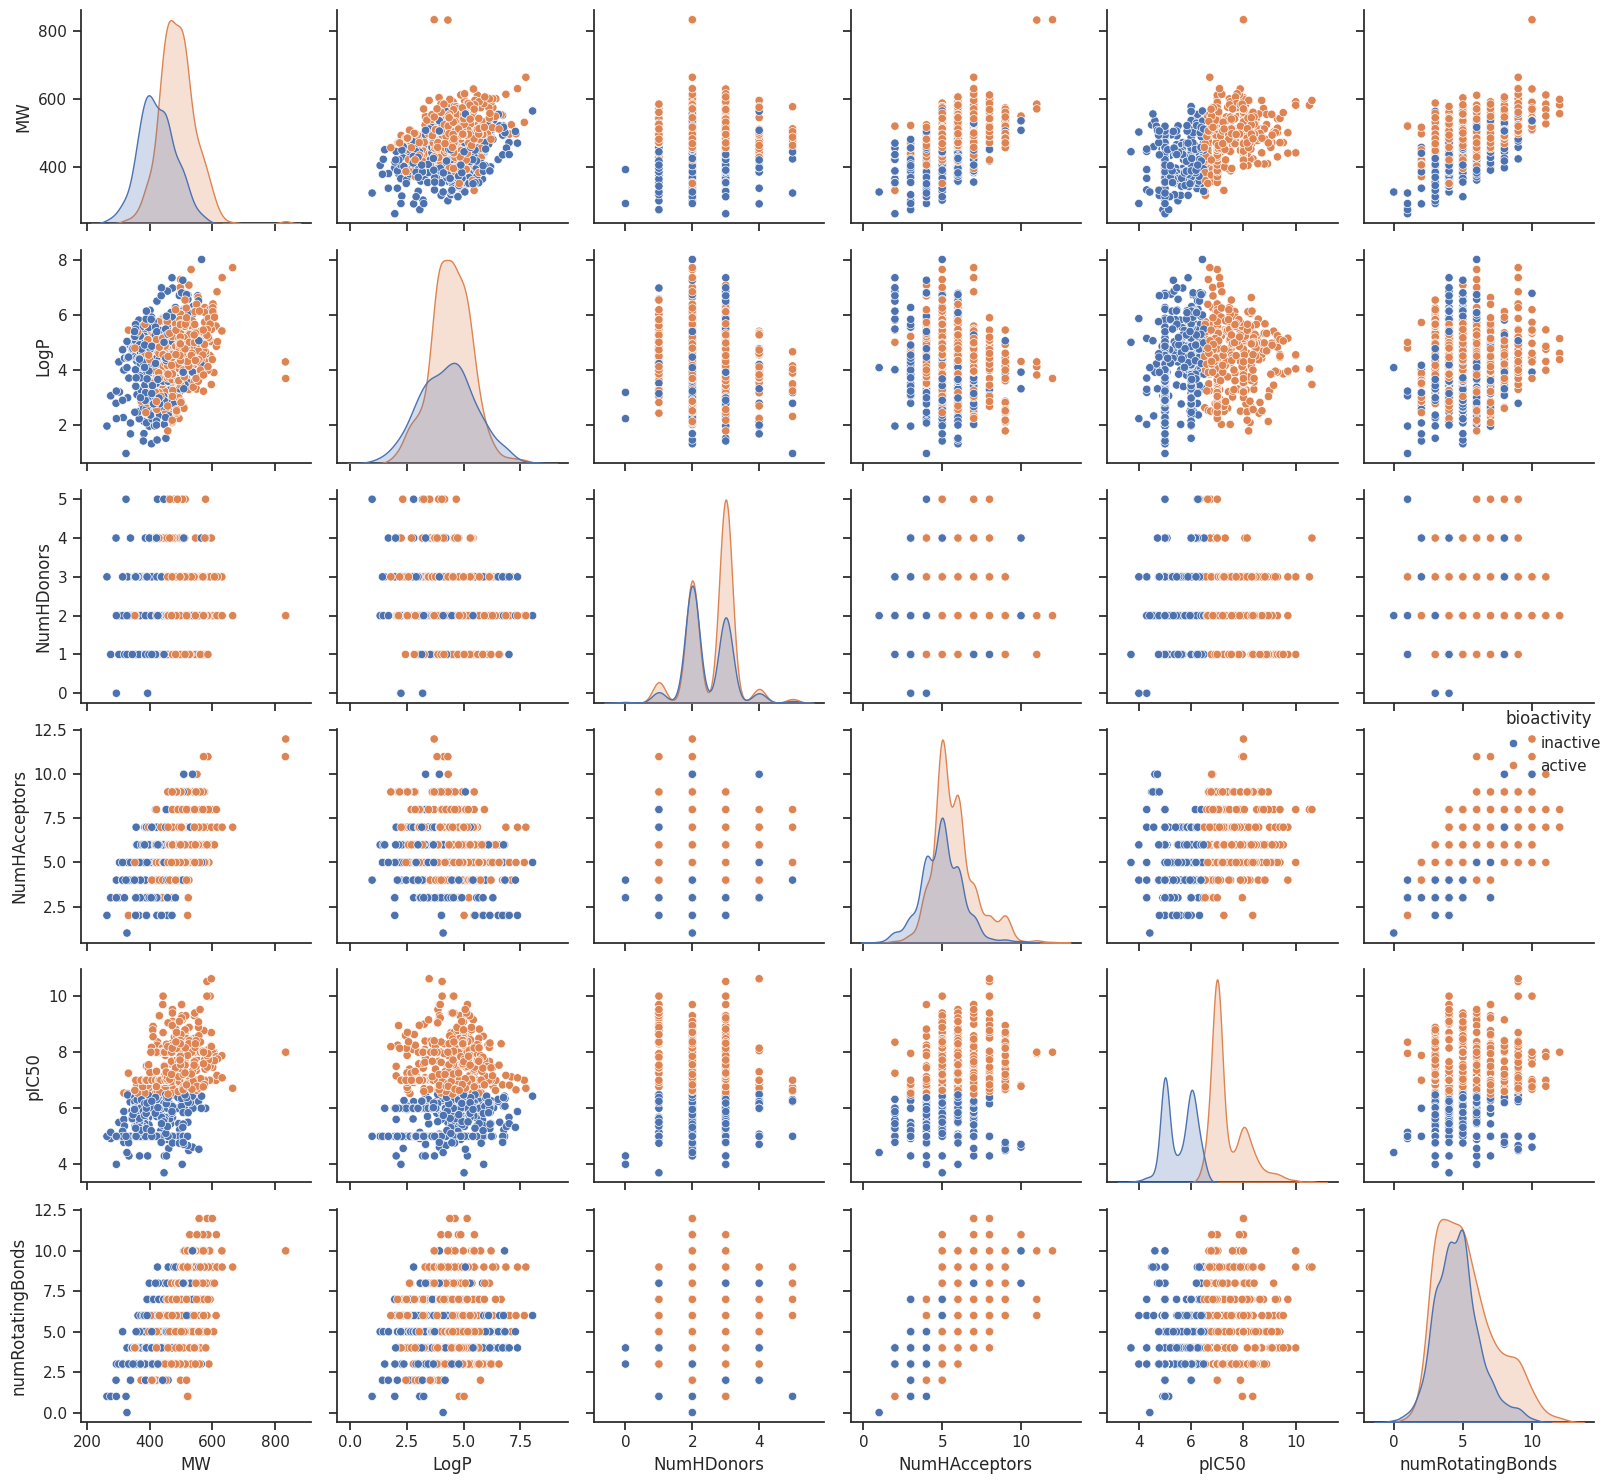

In [66]:
selection = ['bioactivity','MW','LogP','NumHDonors','NumHAcceptors','pIC50', "numRotatingBonds"]
sns.pairplot(exp_data[selection], hue='bioactivity')
plt.tight_layout()
plt.savefig("Pairplot_of_selected data")

In [67]:
exp_data

,molecule_chembl_id,std_smiles,MW,LogP,NumHDonors,NumHAcceptors,numRotatingBonds,norm_value,pIC50,bioactivity
0,CHEMBL431583,COC(=O)c1ccc(-c2[nH]c(-c3ccccc3)nc2-c2ccncc2)cc1,355.397,4.5923,1.0,4.0,4.0,320.0,6.494850,inactive
1,CHEMBL303144,C[C@H](Nc1cc(-c2c(-c3cccc(C(F)(F)F)c3)nc(C3CCN...,505.588,6.8080,2.0,5.0,6.0,810.0,6.091515,inactive
2,CHEMBL305178,C[C@H](Nc1nccc(-c2c(-c3cccc(C(F)(F)F)c3)nc(C3C...,506.576,6.2030,2.0,6.0,6.0,1000.0,6.000000,inactive
3,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,377.444,4.6822,1.0,3.0,4.0,330.0,6.481486,inactive
4,CHEMBL308939,C[C@H](Nc1nccc(-c2[nH]c(C3CCNCC3)nc2-c2cccc(C(...,492.549,6.1926,3.0,5.0,6.0,3500.0,5.455932,inactive
...,...,...,...,...,...,...,...,...,...,...
1086,CHEMBL166031,CC(C)(C)c1cc(NC(=O)Nc2ccc(Oc3ccncc3)cc2)no1,352.394,4.8034,2.0,5.0,4.0,230.0,6.638272,active
1087,CHEMBL2029988,COc1cc2ncnc(Oc3cccc(NC(=O)Nc4cc(C(C)(C)C(F)(F)...,517.464,5.9112,2.0,8.0,7.0,146.0,6.835647,active
1088,CHEMBL361708,Nc1nc(C2=CCNC(=O)c3[nH]c(Br)cc32)c(O)[nH]1,324.138,0.9632,5.0,4.0,1.0,10000.0,5.000000,inactive
1089,CHEMBL296586,O=C1Cc2c([nH]c3ccc(Br)cc23)-c2ccccc2N1,327.181,4.0920,2.0,1.0,0.0,38000.0,4.420216,inactive


# Tests whether the Lipinski rule of five is fullfiled

In [68]:
def fulfilled(df):
  predictions = []

  for i,row in df.iterrows():
        mw = row['MW']
        logp = row['LogP']
        hbd = row['NumHDonors']
        hba = row['NumHAcceptors']
        num_rot_b = row["numRotatingBonds"]

        # Check if all conditions are satisfied
        if mw <= 500 and logp <= 10 and hba <=10 and hbd <=5 and num_rot_b <=5:
            predictions.append(True)
        else:
            predictions.append(False)
  return pd.Series(predictions, name="fullfilment")

In [69]:
ro5_properties = fulfilled(exp_data)

In [70]:
fullfilment_test = pd.concat([exp_data, ro5_properties], axis=1)
fullfilment_test

,molecule_chembl_id,std_smiles,MW,LogP,NumHDonors,NumHAcceptors,numRotatingBonds,norm_value,pIC50,bioactivity,fullfilment
0,CHEMBL431583,COC(=O)c1ccc(-c2[nH]c(-c3ccccc3)nc2-c2ccncc2)cc1,355.397,4.5923,1.0,4.0,4.0,320.0,6.494850,inactive,True
1,CHEMBL303144,C[C@H](Nc1cc(-c2c(-c3cccc(C(F)(F)F)c3)nc(C3CCN...,505.588,6.8080,2.0,5.0,6.0,810.0,6.091515,inactive,False
2,CHEMBL305178,C[C@H](Nc1nccc(-c2c(-c3cccc(C(F)(F)F)c3)nc(C3C...,506.576,6.2030,2.0,6.0,6.0,1000.0,6.000000,inactive,False
3,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,377.444,4.6822,1.0,3.0,4.0,330.0,6.481486,inactive,True
4,CHEMBL308939,C[C@H](Nc1nccc(-c2[nH]c(C3CCNCC3)nc2-c2cccc(C(...,492.549,6.1926,3.0,5.0,6.0,3500.0,5.455932,inactive,False
...,...,...,...,...,...,...,...,...,...,...,...
1086,CHEMBL166031,CC(C)(C)c1cc(NC(=O)Nc2ccc(Oc3ccncc3)cc2)no1,352.394,4.8034,2.0,5.0,4.0,230.0,6.638272,active,True
1087,CHEMBL2029988,COc1cc2ncnc(Oc3cccc(NC(=O)Nc4cc(C(C)(C)C(F)(F)...,517.464,5.9112,2.0,8.0,7.0,146.0,6.835647,active,False
1088,CHEMBL361708,Nc1nc(C2=CCNC(=O)c3[nH]c(Br)cc32)c(O)[nH]1,324.138,0.9632,5.0,4.0,1.0,10000.0,5.000000,inactive,True
1089,CHEMBL296586,O=C1Cc2c([nH]c3ccc(Br)cc23)-c2ccccc2N1,327.181,4.0920,2.0,1.0,0.0,38000.0,4.420216,inactive,True


In [71]:
molecules_ro5_fulfilled = fullfilment_test[fullfilment_test.fullfilment == True]
molecules_ro5_violated = fullfilment_test[fullfilment_test.fullfilment == False]
len(molecules_ro5_fulfilled), len(molecules_ro5_violated)

(625, 466)

#Making radar plot

In [72]:
def calculate_mean_std(dataframe):
    stats = dataframe.describe()
    stats = stats.T
    stats = stats[["mean", "std"]]
    return stats

In [73]:
molecules_ro5_fulfilled_stats = calculate_mean_std(molecules_ro5_fulfilled[['MW','LogP','NumHDonors','NumHAcceptors',"numRotatingBonds"]])
molecules_ro5_violated_stats = calculate_mean_std(molecules_ro5_violated[['MW','LogP','NumHDonors','NumHAcceptors',"numRotatingBonds"]])

In [74]:
selections = ['MW','LogP','NumHDonors','NumHAcceptors',"numRotatingBonds"]
angles=np.linspace(0,2*np.pi,len(selections), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))

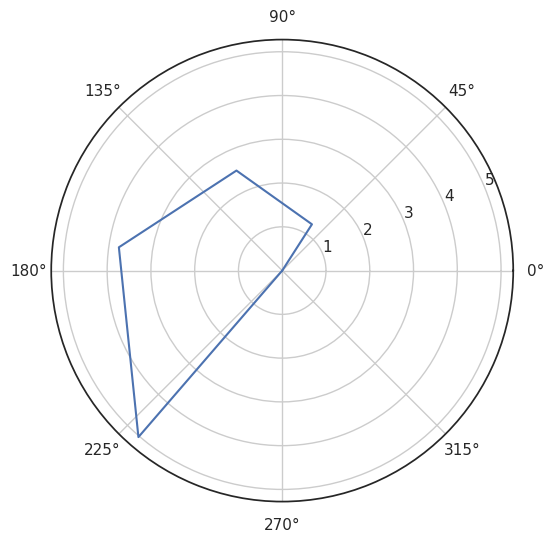

In [75]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(polar=True)
ax.plot(angles)
plt.show()

In [76]:
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    """
    Scale values for different properties that have each an individually defined threshold.

    Parameters
    ----------
    stats : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.

    Returns
    -------
    pd.DataFrame
        DataFrame with scaled means and standard deviations for each physiochemical property.
    """
    # Raise error if scaling keys and data_stats indicies are not matching
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled

In [77]:
def _define_radial_axes_angles(n_axes):
    """Define angles (radians) for radial (x-)axes depending on the number of axes."""
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles

In [78]:
#Code adapted from https://projects.volkamerlab.org/teachopencadd/talktorials/T002_compound_adme.html
def plot_radar(y, thresholds, scaled_threshold, properties_labels, y_max=None, output_path=None):

    x = _define_radial_axes_angles(len(y) - 1)
    y_scaled = _scale_by_thresholds(y, thresholds, scaled_threshold)

    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot data
    ax.fill(x, [scaled_threshold] * len(x), "cornflowerblue", alpha=0.2)
    ax.plot(x, y_scaled["mean"], "b", lw=3, ls="-")
    ax.plot(x, y_scaled["mean"] + y_scaled["std"], "orange", lw=2, ls="--")
    ax.plot(x, y_scaled["mean"] - y_scaled["std"], "orange", lw=2, ls="-.")

    # Set plot cosmetics
    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(180)
    plt.xticks(x, [])
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    plt.ylim(0, y_max)
    plt.yticks(range(1, y_max), ["5" if i == scaled_threshold else "" for i in range(1, y_max)], fontsize=16)

    # Draw ytick labels
    for angle, label in zip(x, properties_labels):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(x=angle, y=y_max + 1, s=label, size=16, horizontalalignment=ha, verticalalignment="center")

    # Add legend
    labels = ("mean", "mean + std", "mean - std", "rule of five area")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)

    # Save plot
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    plt.show()


In [79]:
thresholds = {"MW": 500, "NumHAcceptors": 10, "NumHDonors": 5, "LogP": 5, "numRotatingBonds":5}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# NumHAcceptors / 2",
    "# NumHDonors",
    "LogP",
]
y_max = 8

Radar plot of molecules that fulfill Lipinski rule of five

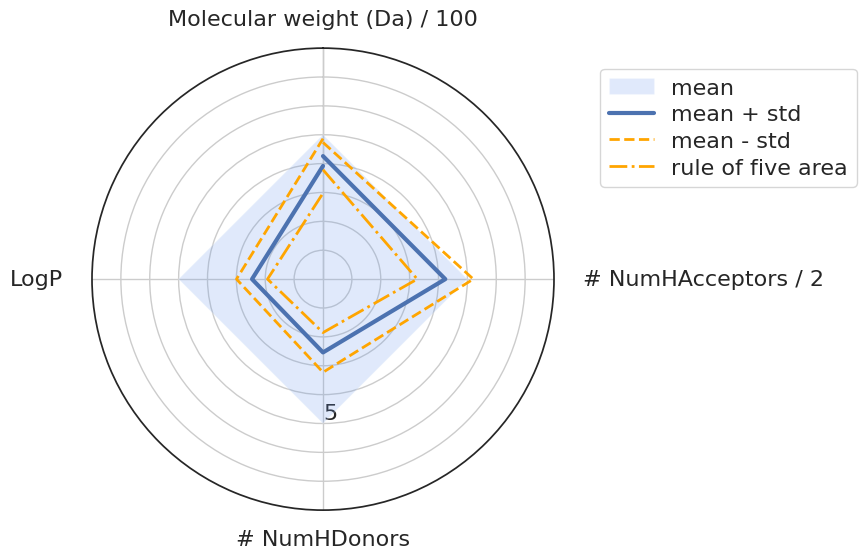

In [80]:
plot_radar(
    molecules_ro5_fulfilled_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

Radar plot of molecules that violate the Lipinski rule of five

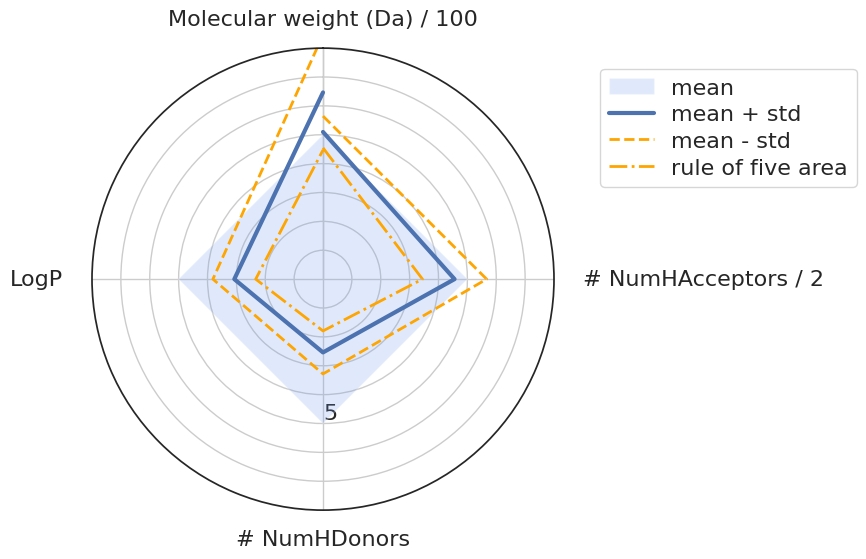

In [81]:
plot_radar(
    molecules_ro5_violated_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)